#### MetaData - Prepared manually by taking the Fitness -https://royalsocietypublishing.org/doi/10.1098/rspb.2015.2292 & the allele count data and sequencing data - https://github.com/benjaminhgood/LTEE-metagenomic.

##### import libary

In [1]:
import sys
sys.path.append("../../..")

In [2]:
import sys
sys.path.append("../../..")
# sys.path.append("../../../data/")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib
from scipy.stats import spearmanr
pd.set_option('mode.chained_assignment', None)

##### Read gain sheet data

In [4]:
df_Gain_calculated = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Gain score")
df_Gain_calculated.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914
1,201,thrL,T->G,T,G,missense,p6,-1.750693
2,241,thrL,A->C,A,C,missense,m1,-0.911836
3,309,thrA,T->G,T,G,noncoding,m1,4.009052
4,322,thrA,A->G,A,G,noncoding,p3,1.532477


In [5]:
df_Gain_calculated[df_Gain_calculated.duplicated(subset=['Position', 'Gene',
 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'])]

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain


##### Read Allele count and generation data from metasheet

In [6]:
df_Alt_allele_count_all_generation = pd.read_excel("../../../data/MetaData_ecoli_final.xlsx", sheet_name= "Mastersheet")
df_Alt_allele_count_all_generation.head()

,CHROM,Position,Gene,Allele,Annotation,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,...,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000,Ref_allele,Alt_allele,label
0,chrI,1554,thrA,C->A,missense,0,1,0,2,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,C,A,p1
1,chrI,1556,thrA,C->A,synonymous,0,0,0,2,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,A,p1
2,chrI,2450,thrA,G->T,synonymous,0,0,0,0,0.0,...,81,41,109.0,129.0,4.0,67.0,8.0,G,T,p1
3,chrI,4274,thrC,C->T,missense,0,0,0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,T,p1
4,chrI,6400,yaaA,T->G,missense,0,0,0,0,2.0,...,0,0,0.0,0.0,0.0,0.0,0.0,T,G,p1


##### Check if any duplicated row

In [7]:
df_Alt_allele_count_all_generation[df_Alt_allele_count_all_generation.duplicated(subset=['Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'])]

,CHROM,Position,Gene,Allele,Annotation,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,...,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000,Ref_allele,Alt_allele,label
2028,chrI,450000,ylaB,A->G,missense,0,0,0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,A,G,p3


##### delete duplicate row in df_Alt_allele_count_all_generation dataframe where duplicate indicate when ['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'] are same in mutiple row


In [8]:
df_Alt_allele_count_all_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Alt_allele_count_all_generation.reset_index(inplace=True, drop=True)
# df_Alt_allele_count_all_generation

In [9]:
df_Alt_allele_count_all_generation.head()

,CHROM,Position,Gene,Allele,Annotation,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,...,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000,Ref_allele,Alt_allele,label
0,chrI,1554,thrA,C->A,missense,0,1,0,2,1.0,...,0,0,1.0,0.0,1.0,0.0,0.0,C,A,p1
1,chrI,1556,thrA,C->A,synonymous,0,0,0,2,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,A,p1
2,chrI,2450,thrA,G->T,synonymous,0,0,0,0,0.0,...,81,41,109.0,129.0,4.0,67.0,8.0,G,T,p1
3,chrI,4274,thrC,C->T,missense,0,0,0,0,0.0,...,0,0,0.0,0.0,0.0,0.0,0.0,C,T,p1
4,chrI,6400,yaaA,T->G,missense,0,0,0,0,2.0,...,0,0,0.0,0.0,0.0,0.0,0.0,T,G,p1


##### Merge Gain score and allele count

In [10]:
df_complete = pd.merge(df_Gain_calculated,df_Alt_allele_count_all_generation, on=['Position','Gene','Allele','Annotation','Ref_allele','Alt_allele','label'], how = "left")
df_complete.head()

,Position,Gene,Allele,Ref_allele,Alt_allele,Annotation,label,accumulated_gain,CHROM,AC:0,...,AC:55500,AC:56000,AC:56500,AC:57000,AC:57500,AC:58000,AC:58500,AC:59000,AC:59500,AC:60000
0,63,intergenic,A->C,A,C,noncoding,p6,-10.385914,chrI,0,...,49,78,45,22,36,39.0,11.0,1.0,1.0,6.0
1,201,thrL,T->G,T,G,missense,p6,-1.750693,chrI,0,...,100,140,93,28,79,62.0,15.0,3.0,0.0,13.0
2,241,thrL,A->C,A,C,missense,m1,-0.911836,chrI,0,...,6,1,2,0,0,0.0,0.0,0.0,0.0,0.0
3,309,thrA,T->G,T,G,noncoding,m1,4.009052,chrI,0,...,0,0,0,0,0,0.0,1.0,2.0,7.0,9.0
4,322,thrA,A->G,A,G,noncoding,p3,1.532477,chrI,0,...,23,24,13,16,26,8.0,30.0,22.0,23.0,0.0


##### Extract the column relavent for current analysis from allele count dataframe (all the generation wise allele count, 'CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label')


In [11]:
filtered_list = [item for item in df_complete if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
filtered_list.extend(['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label', "accumulated_gain"]) ##Add other relavent information
df_allele_generation = df_complete[filtered_list]
df_allele_generation.head() # Get complete dataframe containing all generation wise allele count and other relavent column

,AC:0,AC:1000,AC:1500,AC:2000,AC:2500,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,...,AC:60000,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0.0,0,0,0,0,0,...,6.0,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0.0,0,0,0,0,0,...,13.0,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0.0,0,0,0,0,0,...,9.0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0.0,0,0,0,0,0,...,0.0,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


##### Define mutator and non-mutator population 

In [12]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

##### Find the generation which have missing value 

In [13]:
nan_columns = df_allele_generation.columns[df_allele_generation.isna().any()]
df_with_nan = df_allele_generation[nan_columns]
nan_counts = df_allele_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\n Number of NaN values in each column:")
print(nan_counts)


 Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


##### Drop the generation having nan values

In [14]:
df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
df_allele_generation.reset_index(inplace=True, drop = True)
df_allele_generation.head()

,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57500,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0,0,0,0,0,0,...,36,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0,0,0,0,0,0,...,79,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0,0,0,0,0,0,...,0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0,0,0,0,0,0,...,0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0,0,0,0,0,0,...,26,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477


In [15]:
df_allele_generation

,AC:0,AC:1000,AC:1500,AC:2000,AC:3000,AC:4000,AC:4500,AC:5000,AC:5500,AC:6000,...,AC:57500,CHROM,Position,Gene,Allele,Annotation,Ref_allele,Alt_allele,label,accumulated_gain
0,0,0,0,0,0,0,0,0,0,0,...,36,chrI,63,intergenic,A->C,noncoding,A,C,p6,-10.385914
1,0,0,0,0,0,0,0,0,0,0,...,79,chrI,201,thrL,T->G,missense,T,G,p6,-1.750693
2,0,0,0,0,0,0,0,0,0,0,...,0,chrI,241,thrL,A->C,missense,A,C,m1,-0.911836
3,0,0,0,0,0,0,0,0,0,0,...,0,chrI,309,thrA,T->G,noncoding,T,G,m1,4.009052
4,0,0,0,0,0,0,0,0,0,0,...,26,chrI,322,thrA,A->G,noncoding,A,G,p3,1.532477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36917,0,0,0,0,0,0,0,0,0,0,...,0,chrI,4629541,lasT,C->T,missense,C,T,m2,-4.635292
36918,0,0,0,0,0,0,0,0,0,0,...,0,chrI,4629573,lasT,T->C,synonymous,T,C,m4,-7.657991
36919,0,0,0,0,0,0,0,0,0,0,...,35,chrI,4629600,lasT,A->G,missense,A,G,p3,2.403010
36920,0,0,4,4,6,5,4,14,4,6,...,0,chrI,4629600,lasT,A->G,missense,A,G,p6,2.403010


In [16]:
df_allele_generation["Gene"] = df_allele_generation["Gene"].str.strip()
df_allele_generation["Allele"] = df_allele_generation["Allele"].str.strip()

##### Create dataset having all mutation info in proper form for easy calculation
##### Make a dataframe having column ['label', 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation', 'generation', 'allele count', 'generation_number']

In [17]:
data_all_copy = df_allele_generation.copy()
all_mutation = pd.DataFrame() # The all_mutation dataframe contain generation and population wise accumulated gain

for i in data_all_copy.columns[:-9]:
    new_df_tmp = pd.DataFrame()
    new_df = data_all_copy[data_all_copy.loc[:, i]!=0]
    new_df_tmp = new_df[["label", 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation']]
    new_df_tmp.loc[:, "generation"] = i
    new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulated_gain"]
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
    
all_mutation.reset_index(inplace=True, drop=True)
all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)
for i in range(all_mutation.shape[0]):
    
    if all_mutation.loc[i, "label"] in mutator_list:
        all_mutation.loc[i, "mutator"] = "mutator"
    if all_mutation.loc[i, "label"] in non_mutator_list:
        all_mutation.loc[i, "mutator"] = "non mutator"

all_mutation.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,AG,allele count,generation_number,mutator
0,m6,chrI,1457,thrA,G->A,missense,AC:0,-8.160701,1,0,non mutator
1,m2,chrI,2098,thrA,A->G,missense,AC:0,0.007780,1,0,mutator
2,m2,chrI,2942,thrB,A->G,missense,AC:0,-4.953477,1,0,mutator
3,m4,chrI,5437,yaaX,A->G,missense,AC:0,-10.279634,1,0,mutator
4,m5,chrI,7129,yaaJ,A->C,missense,AC:0,2.182288,2,0,non mutator


##### Remove white spaces from columns

In [18]:
all_mutation["Gene"] = all_mutation["Gene"].str.strip()
all_mutation["Allele"] = all_mutation["Allele"].str.strip()

##### Plot accumulated gain vs type of mutator against essential and non essential gene

In [19]:
df_essential_gene = pd.read_excel("../../../data/gene type.xlsx")
df_essential_gene.head()

,Gene,type
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


##### drop row where gene name is not available

In [20]:
df_essential_gene.dropna(subset=["Gene"], inplace=True)
df_essential_gene.reset_index(inplace=True, drop=True)
df_essential_gene["Gene"] = df_essential_gene["Gene"].str.strip() # Trim white spaces from "Gene" column
df_essential_gene.head()

,Gene,type
0,thrL,non-essential
1,thrA,non-essential
2,thrB,non-essential
3,thrC,non-essential
4,yaaX,non-essential


##### Merge all_mutation with df_essential_gene while using "Gene" as key

##### Store all unique mutation with gene type

In [21]:
df_gene_type_gain = pd.merge(all_mutation, df_essential_gene, on = ["Gene"])
df_gene_type_gain.head()

,label,CHROM,Position,Gene,Allele,Annotation,generation,AG,allele count,generation_number,mutator,type
0,m6,chrI,1457,thrA,G->A,missense,AC:0,-8.160701,1,0,non mutator,non-essential
1,m2,chrI,2098,thrA,A->G,missense,AC:0,0.007780,1,0,mutator,non-essential
2,p4,chrI,1335,thrA,C->T,missense,AC:1000,-7.350176,1,1000,non mutator,non-essential
3,p1,chrI,1554,thrA,C->A,missense,AC:1000,-4.354439,1,1000,non mutator,non-essential
4,p6,chrI,1822,thrA,T->G,missense,AC:1000,-7.098376,1,1000,mutator,non-essential


In [22]:
# df_gene_type_gain

##### kGain vs mutator type with gene type as hue (fig -3a)

In [23]:
mut_ag = df_gene_type_gain[df_gene_type_gain["mutator"].isin(["mutator"])]
mut_ag_essential = mut_ag[mut_ag["type"].isin(["essential "])]
mut_ag_non_essential = mut_ag[mut_ag["type"].isin(["non-essential "])]

print("The one sided Mann-Whitney p- value between essential and non essential for kGain score in mutator category is :", utility.man_whiteney(mut_ag_essential["AG"], mut_ag_non_essential["AG"]))

The one sided Mann-Whitney p- value between essential and non essential for kGain score in mutator category is : 4.591593317348264e-100


In [24]:
non_mut_ag = df_gene_type_gain[df_gene_type_gain["mutator"].isin(["non mutator"])]
non_mut_ag_essential = non_mut_ag[non_mut_ag["type"].isin(["essential "])]
non_mut_ag_non_essential = non_mut_ag[non_mut_ag["type"].isin(["non-essential "])]

print("The one sided Mann-Whitney p- value between essential and non essential for kGain score in non mutator category is :", utility.man_whiteney(non_mut_ag_essential["AG"], non_mut_ag_non_essential["AG"]))

The one sided Mann-Whitney p- value between essential and non essential for kGain score in non mutator category is : 1.0600186819902237e-201


x: non mutator, p-value: 1.06e-201, Cohen's d: 2.91e-01
x: mutator, p-value: 4.59e-100, Cohen's d: 6.80e-02


Text(0, 0.5, 'kGain')

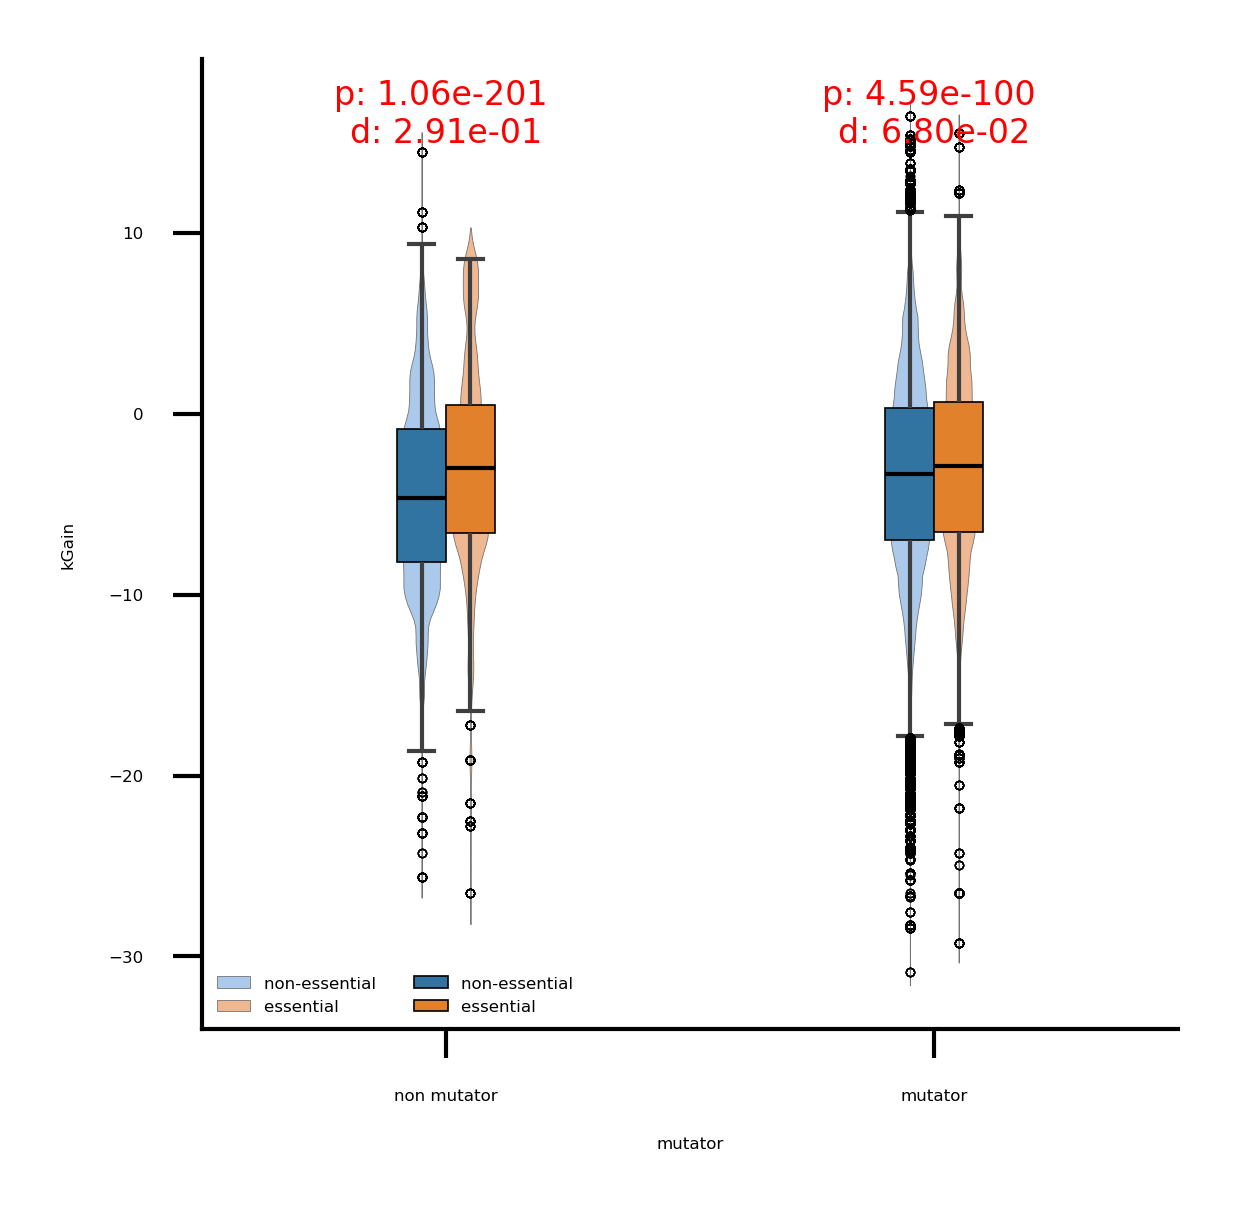

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,  1, dpi = 600, figsize = (2.1, 2.1))
ax = sns.violinplot(data=df_gene_type_gain, x='mutator', y='AG', hue='type', ax=ax, inner='box', width=0.2, palette='pastel', linewidth=0.1, dodge= True)
ax = sns.boxplot(data=df_gene_type_gain, x='mutator', y='AG', hue='type',ax=ax, width=0.2, linewidth=0.5,boxprops=dict(edgecolor="black", linewidth=0.2), flierprops=dict(marker='o', markeredgecolor='black'),fliersize=0.15, dodge=True,medianprops={"color": "black","linewidth":0.5})
ax = utility.custom_figure_axis(ax=ax,fontsize=2,show_ticks=True,rotation=0)
ax.legend(ncol=2,fontsize=2, frameon=False)
ax = utility.return_box_with_p_effect_size(ax, data = df_gene_type_gain, x_columns = 'mutator', y_columns = 'AG', group1_name = 'essential ', group2_name = 'non-essential ', y_pos = 15, hue_columns='type', fontsize=4)

ax.set_ylabel("kGain")

##### fig. 3b, 3c: Median kGain vs generation for mutator and non mutator

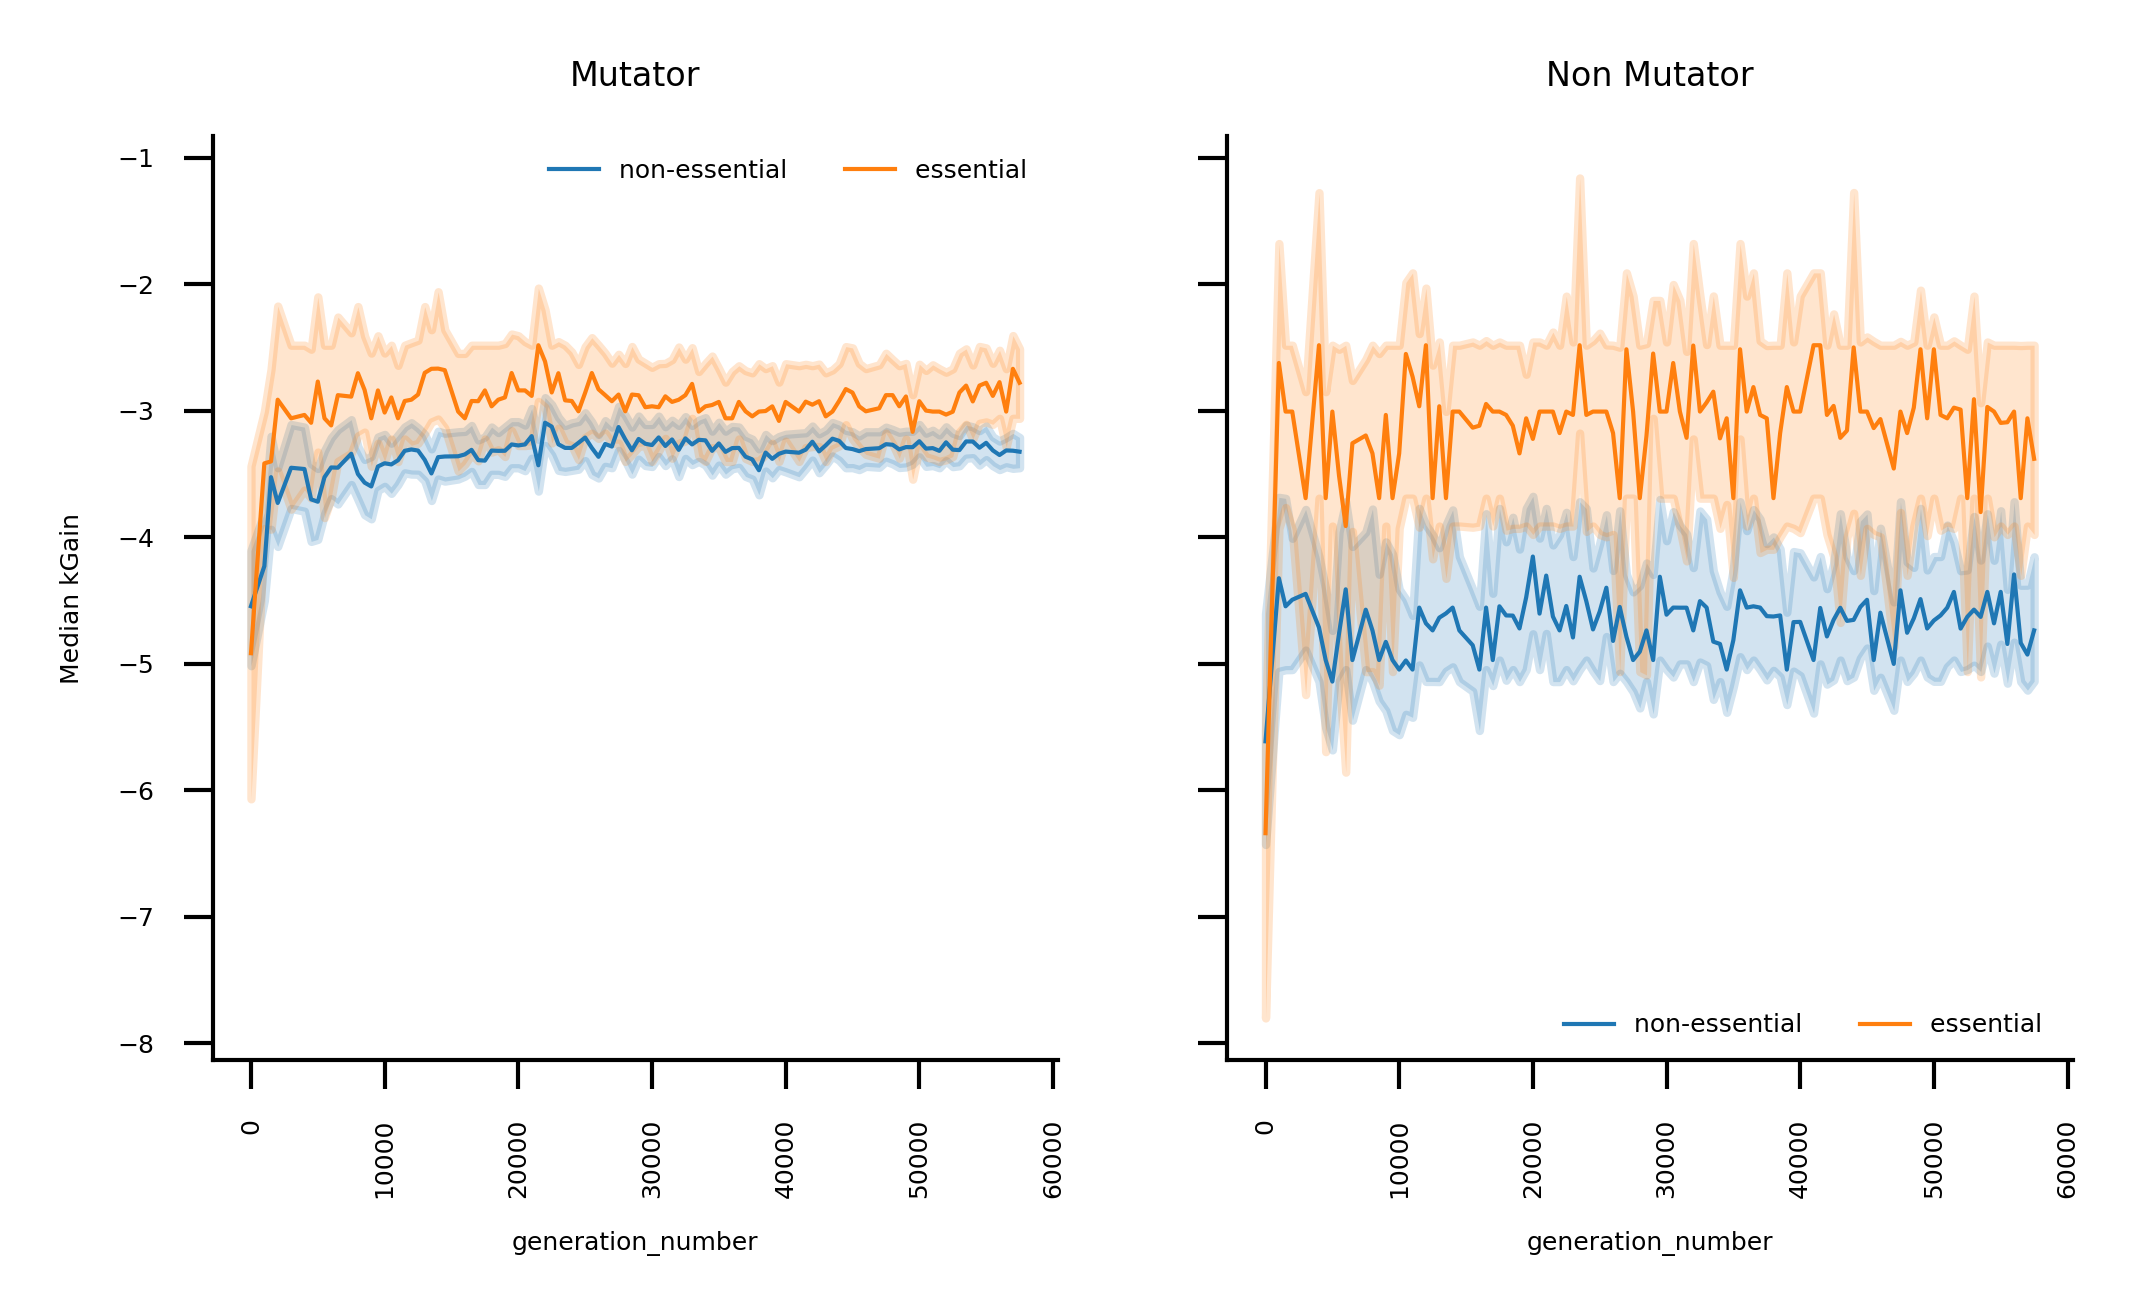

In [26]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, dpi = 600, figsize=(4,2))
sns.lineplot(df_gene_type_gain[df_gene_type_gain["mutator"].isin(["mutator"])], hue="type", x = "generation_number", y = "AG", lw=0.5, estimator="median", ax=ax[0])
sns.lineplot(df_gene_type_gain[df_gene_type_gain["mutator"].isin(["non mutator"])], hue="type", x = "generation_number", y = "AG", lw=0.5, estimator="median", ax=ax[1])

ax[0].set_title("Mutator", fontsize=4)
ax[1].set_title("Non Mutator", fontsize=4)
ax[0].legend(ncol = 2, fontsize=3, frameon=False)
ax[1].legend(ncol = 2, fontsize=3, frameon=False)
ax[0].set_ylabel("Median kGain")
ax[1].set_ylabel("Median kGain")
ax[0] = utility.custom_figure_axis(ax[0], fontsize=3, show_ticks = True)
ax[1] = utility.custom_figure_axis(ax[1], fontsize=3, show_ticks = True)

##### Get allele count across the generation

In [27]:
# Get the columns that start with 'AC'
ac_columns = [col for col in df_allele_generation.columns if col.startswith('AC')]

# Sum the columns column-wise
df_allele_generation["sum of alt AC"] =  df_allele_generation[ac_columns].sum(axis=1)

# df_allele_generation["number_of_mutations"] = (df_allele_generation[ac_columns] != 0).sum(axis=1)
# df_allele_generation["mutation type"] = np.where(df_allele_generation[ 'number_of_mutations'] > df_allele_generation["number_of_mutations"].median(), "Carry forward", "non carry forward") 
# ##### Where number_of_mutations> median number of mutations, assign it Carry forward otherwise assign non carry forward

#### Carry forward vs non carry forward mutation AG plot

In [28]:
df_allele_generation["number_of_mutations"] = (df_allele_generation[ac_columns] != 0).sum(axis=1)
df_allele_generation["mutation type"] = np.where(df_allele_generation[ 'number_of_mutations'] > df_allele_generation["number_of_mutations"].median(), "Carry forward", "non carry forward") 
# all_mutation  = pd.merge(all_mutation, df_allele_generation)
##### Where number_of_mutations> median number of mutations, assign it Carry forward otherwise assign non carry forward

In [29]:
# df_gene_type_gain

In [30]:
# df_allele_generation

In [31]:
# all_mutation

In [32]:
kgain_mutation = pd.merge(all_mutation, df_allele_generation[['CHROM', 'Gene', 'Position', 'label', 'Allele', "mutation type"]].drop_duplicates(), on = ['CHROM', 'Gene', 'Position', 'label', 'Allele'])

In [33]:
kgain_mutation

,label,CHROM,Position,Gene,Allele,Annotation,generation,AG,allele count,generation_number,mutator,mutation type
0,m6,chrI,1457,thrA,G->A,missense,AC:0,-8.160701,1,0,non mutator,non carry forward
1,m6,chrI,1457,thrA,G->A,missense,AC:13500,-8.160701,3,13500,non mutator,non carry forward
2,m6,chrI,1457,thrA,G->A,missense,AC:14000,-8.160701,5,14000,non mutator,non carry forward
3,m6,chrI,1457,thrA,G->A,missense,AC:14500,-8.160701,4,14500,non mutator,non carry forward
4,m6,chrI,1457,thrA,G->A,missense,AC:15500,-8.160701,12,15500,non mutator,non carry forward
...,...,...,...,...,...,...,...,...,...,...,...,...
1048642,m1,chrI,3451617,mrcA,T->G,missense,AC:57500,-10.089323,12,57500,mutator,non carry forward
1048643,m3,chrI,3483431,malT,T->C,missense,AC:57500,-14.953030,1,57500,mutator,non carry forward
1048644,p3,chrI,4087186,pfkA,A->G,synonymous,AC:57500,-0.762140,4,57500,mutator,non carry forward
1048645,m4,chrI,4468996,pepA,C->T,synonymous,AC:57500,-8.767453,2,57500,mutator,non carry forward


##### fig.3d: kGain plot based on citrus utilization for mutator population using 33.5K generation as cut off ()

x: m2, p-value: 7.22e-17, Cohen's d: 3.80e-02
x: m4, p-value: 6.52e-05, Cohen's d: 2.43e-02
x: p3, p-value: 5.29e-08, Cohen's d: 3.15e-02
x: m3, p-value: 9.31e-66, Cohen's d: 1.77e-01
x: p6, p-value: 1.00e+00, Cohen's d: -1.76e-02
x: m1, p-value: 1.03e-03, Cohen's d: 1.83e-02


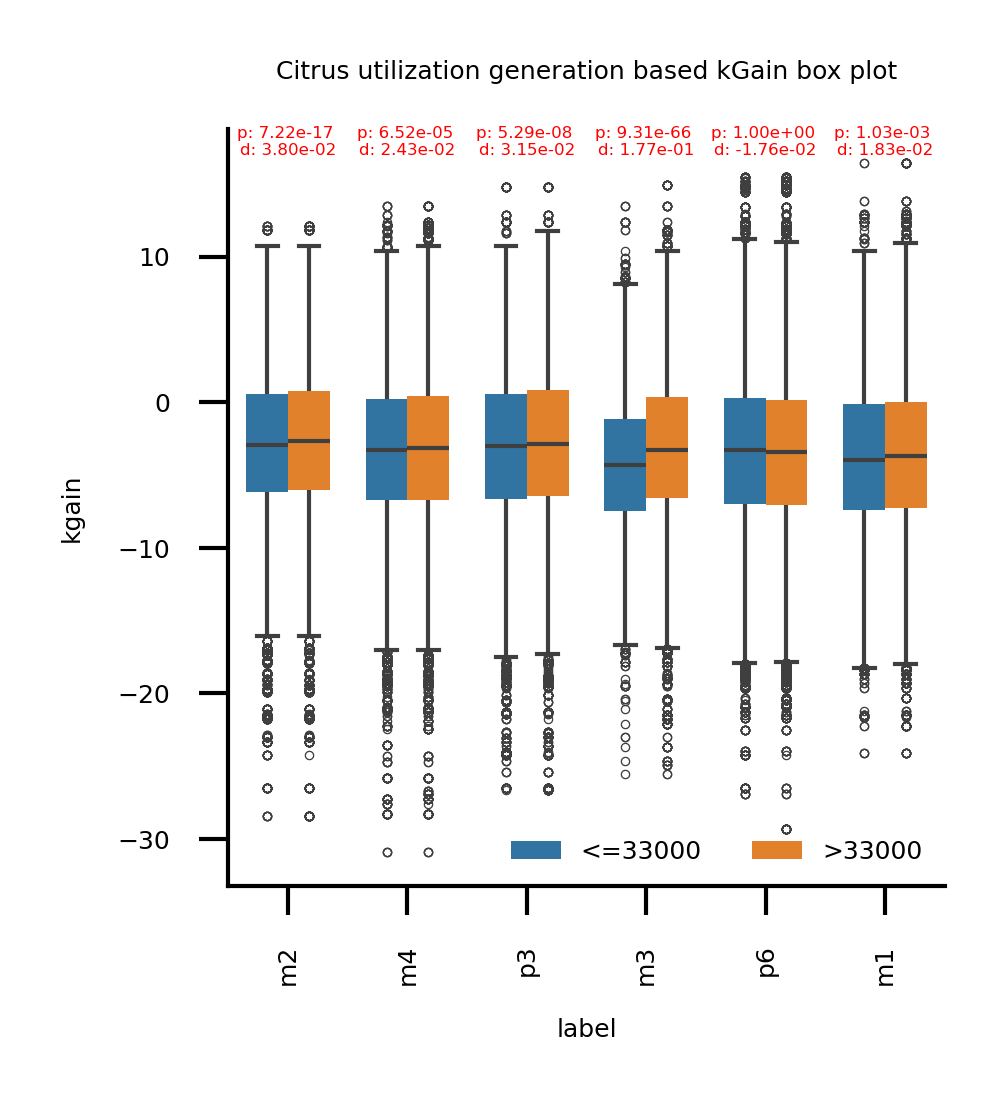

In [34]:
all_mutation["citrus_utilization_gen"]= np.where(all_mutation['generation_number'] <=33000, "<=33000", '>33000')
fig, ax = plt.subplots(1, 1, dpi = 600, figsize =(2.1,2.1))
ax = sns.boxplot(all_mutation[all_mutation["label"].isin(mutator_list)], x = "label", y = "AG", hue = "citrus_utilization_gen", ax=ax, boxprops=dict(edgecolor="black", linewidth=0), width=0.7,linewidth=0.5, fliersize=0.15, dodge=True)
# ax = utility.box_plot(data= all_mutation, x = 'label', y = 'AG', ax = ax)
ax.set_title("Citrus utilization generation based kGain box plot", fontsize=3)
ax.set_ylabel("kgain")
ax = utility.return_box_with_p_effect_size(ax, data = all_mutation[all_mutation["label"].isin(mutator_list)], x_columns = 'label', y_columns = 'AG', group1_name = '>33000', group2_name = '<=33000', y_pos = 17, hue_columns='citrus_utilization_gen', fontsize=2)
plt.tight_layout()
ax = utility.custom_figure_axis(ax, fontsize=3, show_ticks = True)
ax.legend(ncol=2, fontsize=3, frameon=False)

#plt.savefig("../figure/citrus utilization based AG graph ecoli.pdf", dpi=600)

In [35]:
# Perform Mann-Whitney U test for each label separately and print the test statistics and p-values
for label in mutator_list:
    data_low = all_mutation[(all_mutation["label"] == label) & (all_mutation['citrus_utilization_gen'] == '<=33000')]['AG']
    data_high = all_mutation[(all_mutation["label"] == label) & (all_mutation['citrus_utilization_gen'] == '>33000')]['AG']
    
    p_value = utility.man_whiteney(data_high, data_low)  # Switched data1 and data2
    # print(utility.man_whiteney(data_high, data_low))
    
    print(f"{label}: Mann-Whitney U Test  p-value = {p_value}")

m1: Mann-Whitney U Test  p-value = 0.0010343265452248272
m2: Mann-Whitney U Test  p-value = 7.215777409719651e-17
m3: Mann-Whitney U Test  p-value = 9.313114457213662e-66
m4: Mann-Whitney U Test  p-value = 6.524366015866302e-05
p3: Mann-Whitney U Test  p-value = 5.291367933576702e-08
p6: Mann-Whitney U Test  p-value = 0.9999999992241883


In [36]:
# df_gene_type_gain

##### fig. 3e: Non mutator carry forward vs deletoreous mutation AG ()

x: m6, p-value: 1.27e-57, Cohen's d: 4.40e-01
x: m5, p-value: 4.08e-01, Cohen's d: 4.40e-03
x: p2, p-value: 3.64e-33, Cohen's d: 3.93e-01
x: p4, p-value: 5.37e-40, Cohen's d: 2.99e-01
x: p5, p-value: 1.43e-09, Cohen's d: 2.00e-01
x: p1, p-value: 1.07e-07, Cohen's d: 5.21e-02


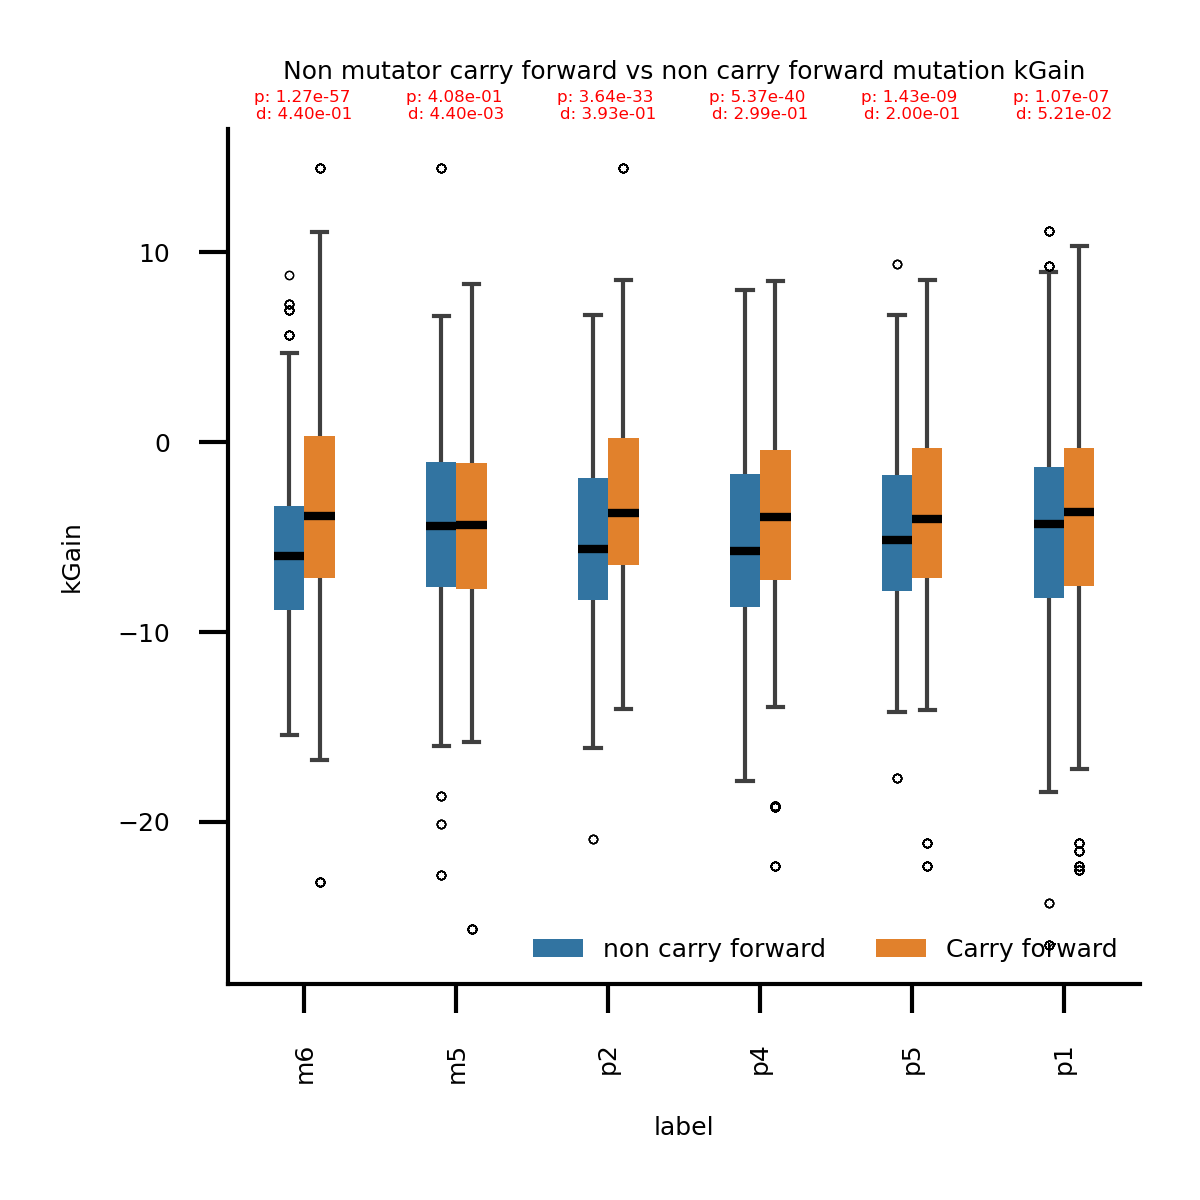

In [37]:
fig, ax = plt.subplots(1, 1, dpi = 600, figsize = (2.1, 2.1))

ax = sns.boxplot(kgain_mutation[kgain_mutation["label"].isin(non_mutator_list)], x = "label", y = "AG", hue = "mutation type", ax=ax, boxprops=dict(edgecolor="black", linewidth=0), flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1})
ax= utility.custom_figure_axis(ax, fontsize=3, show_ticks = True)
ax.legend(ncol = 2, fontsize=3, frameon=False)
ax.set_title("Non mutator carry forward vs non carry forward mutation kGain", fontsize=3)
ax.set_ylabel("kGain")
ax = utility.return_box_with_p_effect_size(ax, data = kgain_mutation[kgain_mutation["label"].isin(non_mutator_list)], x_columns = 'label', y_columns = 'AG', group1_name = 'Carry forward', group2_name = 'non carry forward', y_pos = 17, hue_columns="mutation type", fontsize=2)


plt.tight_layout()

# plt.savefig("../figure/Non mutator carry forward vs deletoreous mutation AG.pdf", dpi = 600)

##### fig.3f: mutator carry forward vs non carry forward mutation AG

x: m2, p-value: 4.92e-69, Cohen's d: 1.42e-01
x: m4, p-value: 6.11e-23, Cohen's d: 5.17e-02
x: p3, p-value: 3.12e-12, Cohen's d: 4.09e-02
x: m3, p-value: 2.23e-06, Cohen's d: 4.46e-02
x: p6, p-value: 3.82e-103, Cohen's d: 1.08e-01
x: m1, p-value: 3.87e-01, Cohen's d: -4.53e-03


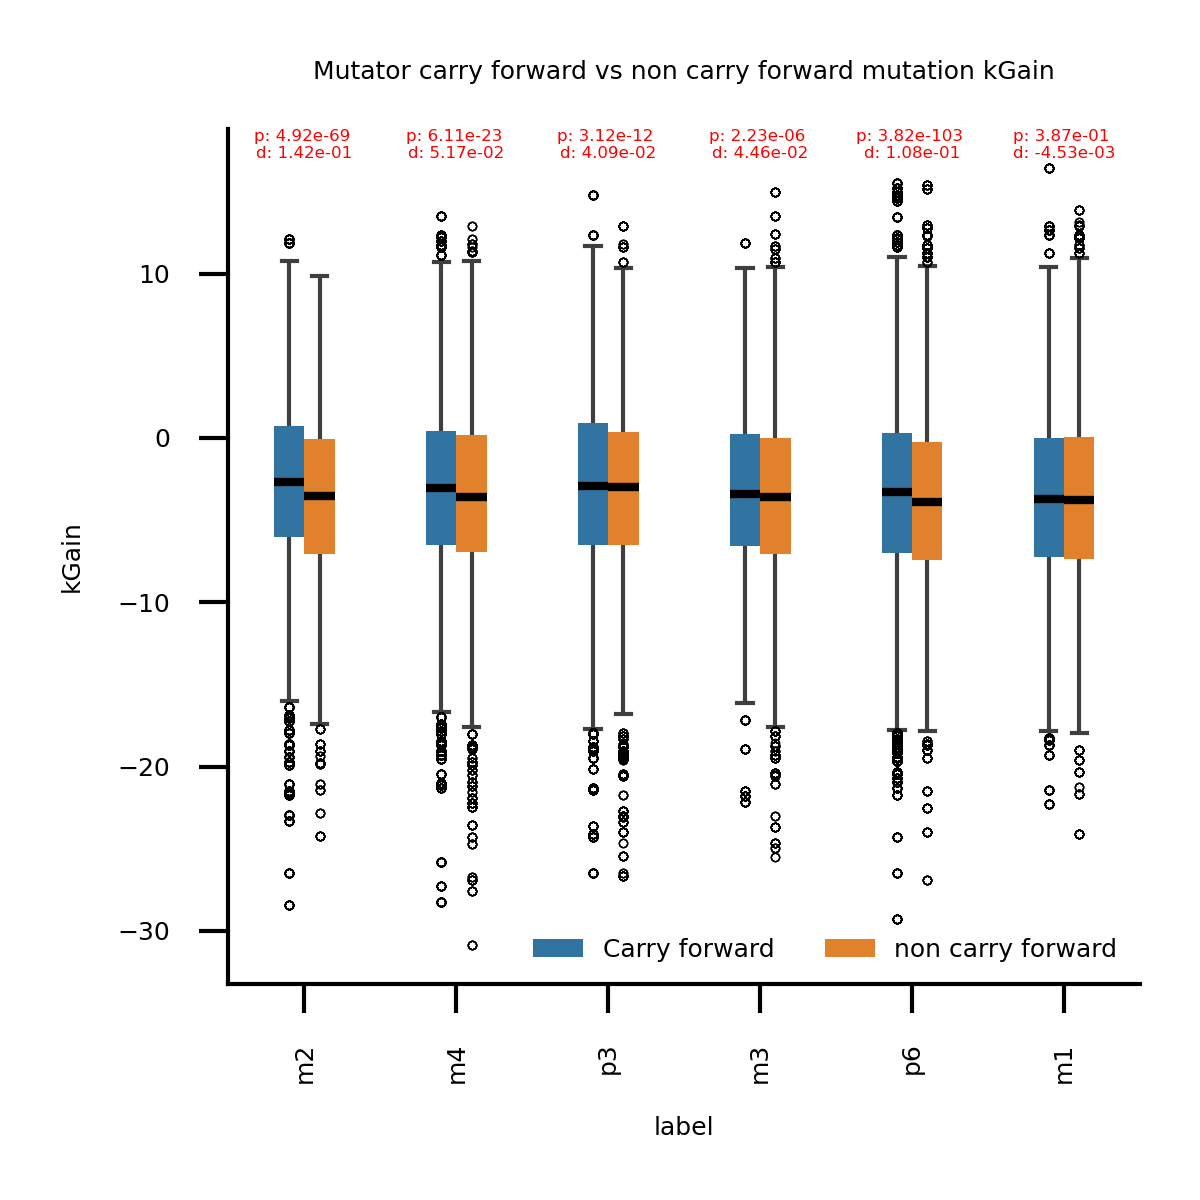

In [38]:
fig, ax = plt.subplots(1, 1, dpi = 600, figsize = (2.1, 2.1))

ax = sns.boxplot(kgain_mutation[kgain_mutation["label"].isin(mutator_list)], x = "label", y = "AG", hue = "mutation type", ax=ax, boxprops=dict(edgecolor="black", linewidth=0), flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, dodge=True, medianprops={"color": "black","linewidth":1})
ax= utility.custom_figure_axis(ax, fontsize=3, show_ticks = True)
ax.legend(ncol = 2, fontsize=3, frameon=False)
ax.set_title("Mutator carry forward vs non carry forward mutation kGain", fontsize=3)
ax.set_ylabel("kGain")
ax = utility.return_box_with_p_effect_size(ax, data = kgain_mutation[kgain_mutation["label"].isin(mutator_list)], x_columns = 'label', y_columns = 'AG', group1_name = 'Carry forward', group2_name = 'non carry forward', y_pos = 17, hue_columns="mutation type", fontsize=2)

plt.tight_layout()
# plt.savefig("../figure/Mutator carry forward vs deletoreous mutation AG.pdf", dpi = 600)


##### Obtain one sided p value in mutator for carry forward vs non carry forward

In [39]:
pop_i = None
pop_i_carry_forward = None
pop_i_non_carry_forward = None

for i in mutator_list:

    pop_i = kgain_mutation[kgain_mutation["label"].isin([i])]
    pop_i_carry_forward = pop_i[pop_i.loc[:, "mutation type"]=="Carry forward"]
    pop_i_non_carry_forward= pop_i[pop_i.loc[:, "mutation type"]=="non carry forward"]
    print("The one sided p value for carry forward vs non carry forward for population " + i + " in kGain is : " + str(utility.man_whiteney(pop_i_carry_forward["AG"], pop_i_non_carry_forward["AG"])))
    pop_i = None
    pop_i_carry_forward = None
    pop_i_non_carry_forward = None

The one sided p value for carry forward vs non carry forward for population m1 in kGain is : 0.3869130710294265
The one sided p value for carry forward vs non carry forward for population m2 in kGain is : 4.924644518925173e-69
The one sided p value for carry forward vs non carry forward for population m3 in kGain is : 2.2320647640215856e-06
The one sided p value for carry forward vs non carry forward for population m4 in kGain is : 6.107712349979822e-23
The one sided p value for carry forward vs non carry forward for population p3 in kGain is : 3.1181689481082093e-12
The one sided p value for carry forward vs non carry forward for population p6 in kGain is : 3.8159583006916344e-103


##### Obtain one sided p value in non mutator for carry forward vs non carry forward

In [40]:
pop_i = None
pop_i_carry_forward = None
pop_i_non_carry_forward = None


for i in non_mutator_list:

    pop_i = kgain_mutation[kgain_mutation["label"].isin([i])]
    pop_i_carry_forward = pop_i[pop_i.loc[:, "mutation type"]=="Carry forward"]
    pop_i_non_carry_forward= pop_i[pop_i.loc[:, "mutation type"]=="non carry forward"]
    print("The one sided p value for carry forward vs non carry forward for population " + i + " in kGain is : " + str(utility.man_whiteney(pop_i_carry_forward["AG"], pop_i_non_carry_forward["AG"])))
    pop_i = None
    pop_i_carry_forward = None
    pop_i_non_carry_forward = None
    

The one sided p value for carry forward vs non carry forward for population p1 in kGain is : 1.0665902958738122e-07
The one sided p value for carry forward vs non carry forward for population p2 in kGain is : 3.638508631067027e-33
The one sided p value for carry forward vs non carry forward for population p4 in kGain is : 5.373157631609266e-40
The one sided p value for carry forward vs non carry forward for population p5 in kGain is : 1.4258050588720623e-09
The one sided p value for carry forward vs non carry forward for population m5 in kGain is : 0.4075510641634176
The one sided p value for carry forward vs non carry forward for population m6 in kGain is : 1.267020775935154e-57
